In [1]:
import numpy as np 
import scipy.stats as ss 
import matplotlib.pyplot as plt

In [2]:
xi = np.linspace(-3,3,100)
X,Y = np.meshgrid(xi,xi)

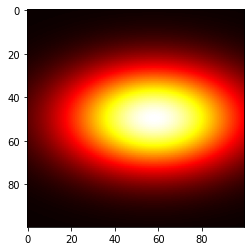

In [3]:
x = np.array(list(zip(X.flatten(), Y.flatten())))
mean = [0.5,0]
cov = [[3.0, 0.5],
       [0.0, 1.0]]
p = ss.multivariate_normal.pdf(x, mean=mean, cov=cov)
p_sq = p.reshape((100,100))


fig, ax = plt.subplots()
plt.imshow(p_sq, cmap='hot')

We want to sample from this target distribution $$\pi\left(\vec{q}\right) = \mathcal{N}\left(\vec{q}; \vec{\mu}, \Sigma\right)) $$ which is unknown in practice.

We will introduce the auxiliary momentum variables $\vec{p}$, and write the joint distribution over all variables as $$ \pi\left(\vec{q},\vec{p}\right) = \pi\left(\vec{p}\middle| \vec{q}\right)\pi\left(\vec{q}\right)$$ For simplicity we will choose the conditional $$ \pi\left(\vec{p}\middle|\vec{q}\right) = \mathcal{N}\left(\vec{0}, I\right)$$ This distribution tells us how to sample our momenta about based on our current position. In general this might depend on our position $\vec{q}$, but here it does not.

The Hamiltonian is $$ \begin{align} H\left(\vec{q},\vec{p}\right) & = -\log \pi \left(\vec{p}\middle|\vec{q}\right) - \log \pi \left(\vec{q}\right) \\ & = K\left(\vec{p},\vec{q}\right) + V\left(\vec{q}\right) \end{align} $$

Hamilton's equations are $$ \begin{align} \frac{d\vec{q}}{dt} & = \frac{\partial K}{\partial \vec{p}} + \frac{\partial V}{\partial \vec{p}} \\ \frac{d\vec{p}}{dt} & = -\frac{\partial K}{\partial \vec{q}} - \frac{\partial V}{\partial \vec{q}} \end{align} $$

With our choice of kinetic energy, $K\left(\vec{p},\vec{q}\right) = -\log \pi\left(\vec{p}\middle| \vec{q}\right)$, we have $$ \begin{align} \frac{d\vec{q}}{dt} & = \vec{p} \\ \frac{d\vec{p}}{dt} & = -\frac{\partial V}{\partial \vec{q}} \end{align} $$

To perform the Monte Carlo random walk, from our initial $\vec{q}$ we sample a momentum $$ \vec{p} \sim \pi\left(\vec{p}\middle|\vec{q}\right) = \mathcal{N}\left(\vec{0},I\right) $$

We evolve $\left(\vec{q},\vec{p}\right)\left(t\right)$ for a short time according to the system of PDE above (this is where numerical integration, and maybe autodiff (?) come into play). The updated value $\vec{q}\left(t+\delta t\right)$ is used for our next iteration.

At this point, we need

* a way to calculate $\frac{\partial V}{\partial \vec{q}} = \frac{\partial}{\partial \vec{q}} \left( -\log \pi \left(\vec{q}\right) \right) $
* a way to perform the numerical integration of the system
* an implementation of the Metropolis acceptance criterion for the proposed new point $\left(\vec{q},\vec{p}\right)\left(t+\delta t\right)$

$p(\theta | x) \propto p(x|\theta)p(\theta)$

In [6]:
cov_inv_T = np.linalg.inv(cov).T

def leapfrog(q,p, dVdq, dT, delta_t):
    """ 
        dT is total integration time
        delta_t is time step size (small)

        Could have also used other schemes
    """

    # specify our velocity equation
    A = lambda x: - x.T @ cov_inv_T


    q, p = np.copy(q), np.copy(p)

    for _ in range(int(dT / delta_t)-1):
        p = p + A(q) * delta_t / 2
        q = q + p * delta_t 
        p = p + A(q) * delta_t / 2

    return(q,p)



In [7]:
q = np.array([1.,1.])
p = np.array([0.,0.])
dVdq = None 
dT = 1. 
delta_t = 0.1

In [8]:
q,p = leapfrog(q,p,dVdq, dT, delta_t)
print(q, p)

[0.92963909 0.62131585] [-0.16260218 -0.78258016]


In [9]:
num_samples = 2000

trace = np.zeros(shape=(num_samples,2))

trace[0,:] = [1.0,.0] # initial starting point
p = np.random.multivariate_normal(mean=mean, cov=cov, size=(1))[0]
for n in range(1,num_samples):
    
    # print("q: ",q)
    # draw a momentum from Pr(p|q)
    q_o= trace[n-1,:]
    p_o = p
    p = np.random.multivariate_normal(mean=mean, cov=cov, size=(1))[0]

    # run the dynamics for a certain amount of time
    q_f, p_f = leapfrog(q_o, p_o, _, 1, 0.01)

    # Metropolis-Hastings acceptance criterion step
    # log_prob = log Pr(p|q) - log Pr(q)
    log_p_o = np.log( np.exp(-0.5 * p_o.T @ p_o )/(2*np.pi) ) \
        - np.log( np.exp(-0.5* (q_o-mean).T @ cov_inv_T.T @ (q_o-mean)) / np.sqrt((2*np.pi)**2 * np.linalg.det(cov)))
    log_p_f = np.log( np.exp(-0.5 * p.T @ p )/(2*np.pi) ) \
        - np.log( np.exp(-0.5* (q-mean).T @ cov_inv_T.T @ (q-mean)) / np.sqrt((2*np.pi)**2 * np.linalg.det(cov)))

    if np.log(np.random.rand()) < log_p_o - log_p_f:
        # print("     accepted")
        trace[n,:] = q_f
    else:
        # print("rejected")
        trace[n,:] = q_o


In [10]:
trace

array([[ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.63352809, -0.79170534],
       ...,
       [ 0.74660061, -0.79610999],
       [ 0.74660061, -0.79610999],
       [ 0.46155284,  0.04361388]])

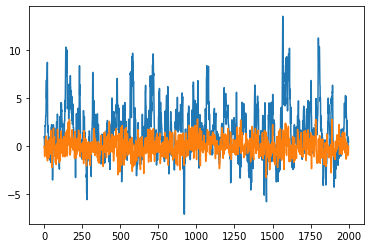

In [11]:
plt.plot(trace[:,0])
plt.plot(trace[:,1])

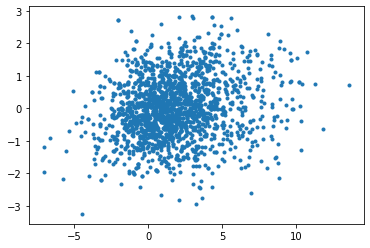

In [12]:
plt.plot(trace[:,0], trace[:,1], '.')

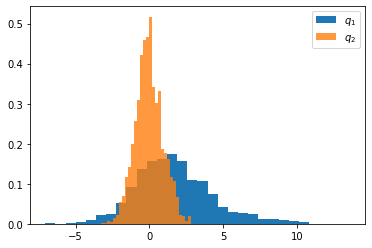

In [13]:
plt.hist(trace[:,0], bins=30, label=r'$q_1$', density=True);
plt.hist(trace[:,1], bins=30, label=r'$q_2$', density=True, alpha=0.8);
plt.legend()

In [14]:
burn_in = 500

print("x mean: ", np.mean(trace[burn_in:,0]))
print("y mean: ", np.mean(trace[burn_in:,1]))

x mean:  1.6958464449122854
y mean:  0.008909707175932648


# Bayesian lin reg with HMC


The model is $$ \begin{align} y & \sim \mathcal{N}\left(\beta^T X, \sigma^2 I \right) \\ \beta_i & \sim \text{U}\left[-3,3\right] \\ \sigma^2 & \sim \text{U}\left[0,10 \right]\end{align} $$ these are uninformative priors. In this case we have $$\vec{q} =\left(\beta, \sigma^2\right)$$ Let's introduce the momentum variables $$ \vec{p} = \left(p_{\beta}, p_{\sigma^2}\right)$$

The target distribution here is now the joint $$ \pi \left(\vec{q},\vec{p}\right) = \pi\left(\vec{p}\middle|\vec{q}\right)\pi\left(\vec{q}\right) $$ 

We make the choice of $$ \pi\left(\vec{p}\middle|\vec{q}\right) = \mathcal{N}\left(0,I\right)$$ for utmost simplicity.

Since this HMC is wrapped in the Bayesian framework, be sure to keep in mind that the target distibution $\pi\left(\vec{q}\right)$ which we are trying to sample from is really the posterior conditional distribution of the parameters over the data, i.e., $$ \pi\left(\vec{q}\right) = \text{Pr}\left(\beta,\sigma^2\middle| X,\vec{y}\right)$$

As prescribed by HMC, we now take the log of the joint and decompose: $$\begin{align} H\left(\vec{q},\vec{p}\right) & = - \log \pi\left(\vec{q},\vec{p}\right) \\ & = -\log \pi\left(\vec{p}\middle|\vec{q}\right) - \log \pi\left(\vec{q}\right) \\ & = K\left(\vec{q},\vec{p}\right) + V\left(\vec{q}\right) \end{align} $$

Hamilton's equations are $$ \begin{align} \frac{d\vec{q}}{dt} & = \frac{\partial K}{\partial \vec{p}} + \frac{\partial V}{\partial \vec{p}} \\ \frac{d\vec{p}}{dt} & = -\frac{\partial K}{\partial \vec{q}} - \frac{\partial V}{\partial \vec{q}} \end{align} $$

Since $V$ is a function of $\vec{q}$ alone, and since our choice of $K$ is independent of $\vec{q}$, this system reduces to $$ \begin{align} \frac{d\vec{q}}{dt} & = \vec{p}  \\ \frac{d\vec{p}}{dt} & =  - \frac{\partial V}{\partial \vec{q}} \end{align} $$

where $$ -\frac{\partial V}{\partial \vec{q}} = \frac{\partial}{\partial \vec{q}} \log \pi\left(\vec{q}\right) $$

and $\pi\left(\vec{q}\right)$ is, again, the posterior distribution we want. We only know it as the product of the likelihood and the priors up to a multiplicative factor (the inverse evidence), but this is enough to compute the derivative (?).

We can expand this posterior as $$ \pi\left(\vec{q}\right) = \prod_{i=1}^N\mathcal{N}\left(y_i; \beta^Tx_i, \sigma^2I\right)\text{U}\left(\sigma^2;0,10\right) \prod_{k} \text{U}\left(\beta_k ; -3, 3\right) $$ where the factors on the right are all densities. Specifically, this is $$ \pi\left(\vec{q}\right) = \frac{1}{10}\cdot \frac{1}{3^K} \prod_{i=1}^N \left[\frac{1}{\sqrt{2\pi \sigma^2}} \exp \left(-\frac{1}{2\sigma^2}\left(y_i-\beta^Tx_i\right)^2 \right)\right]$$

Taking the negative log, we get $$V\left(\vec{q}\right)=-\log  \pi\left(\vec{q}\right) = \log 10\cdot 3^2 +\frac{N}{2} \log 2\pi \sigma^2 + \frac{1}{2\sigma^2}\sum_{i=1}^N\left(y_i-\beta^Tx_i\right)^2 $$

The gradients are $$ \frac{\partial V}{\partial \sigma^2} = \frac{N}{2\sigma^2} - \frac{1}{2\left(\sigma^2\right)^2}\sum_{i=1}^N \left(y_i-\beta^T x_i\right)^2 $$ and $$ \frac{\partial V}{\partial \beta_k} = - \sum_{i=1}^N \frac{x_{i,k}}{\sigma^2}\left(y_i-\beta^T x_i\right) $$ where $x_i$ is the $i$th sample and $x_{i,k}$ is the $k$th component of the $i$th sample.

Now we can see that our velocity equation has become far more complicated. It is a vector with terms involving sums over the dataset.

In [15]:
import numpy as np 
import scipy.stats as ss

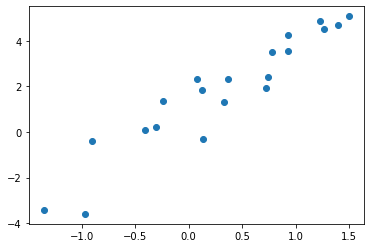

In [16]:
x = 3*np.random.rand(20) - 1.5
y = 1.2 + 2.7 * x + .8*np.random.randn(20)

plt.scatter(x,y); plt.show()

In [17]:
def dVdq(q):
    """
        Implement this!

        q = [sigma^2, beta_0, beta_1]
    """

    residual = y - (q[1] + q[2]*x)

    sig_term = (len(x)/(2*q[0])) - ( np.sum(residual**2) ) / (2*q[0]**2)
    beta_1_term = -np.sum( x * residual ) / q[0] # slope
    beta_0_term = -np.sum(residual) / q[0]

    return np.array([sig_term, beta_0_term, beta_1_term])



def leapfrog(q,p, dVdq, dT, delta_t):
    """ 
        dT is total integration time
        delta_t is time step size (small)
    """
    q, p = np.copy(q), np.copy(p)

    for _ in range(int(dT / delta_t)-1):
        p = p + dVdq(q) * delta_t / 2
        q = q + p * delta_t 
        p = p + dVdq(q) * delta_t / 2

    return(q,p)



In [18]:
num_samples = 10000

trace = np.zeros(shape=(num_samples,3)) # sigma^2, beta_0, beta_1
trace[0,:] = [1.,1.,1.] # starting point

p_f = np.random.multivariate_normal(mean=[0,0,0], cov=0.6*np.eye(3), size=(1))[0]

for n in range(1,num_samples):
    # draw a new momentum from Pr(q|p)
    q_o = trace[n-1,:]
    p_o = p_f 
    p_f = np.random.multivariate_normal(mean=[0,0,0], cov=0.6*np.eye(3), size=(1))[0]

    # run the dynamics
    q_f, p_f = leapfrog(q_o, p_f, dVdq, .005, 0.001)

    # MH acceptance
    residual = y - (q_f[1] + q_f[2]*x)

    log_p_o = - 0.5*len(x)*np.log(2*np.pi*q_o[0]) - 0.5*np.sum( residual**2 )/q_o[0]
    log_p_f = - 0.5*len(x)*np.log(2*np.pi*q_f[0]) - 0.5*np.sum( residual**2 )/q_f[0]

    # print("log_p_o: ", log_p_o)
    # print("log_p_f: ", log_p_f)
    if np.log(np.random.rand()) < log_p_o - log_p_f:
        # print("     accepted")
        trace[n,:] = q_f
    else:
        # print("rejected")
        trace[n,:] = q_o

$$ \log  \pi\left(\vec{q}\right) = -\frac{N}{2} \log 2\pi \sigma^2 - \frac{1}{2\sigma^2}\sum_{i=1}^N\left(y_i-\beta^Tx_i\right)^2 + \text{const.}$$

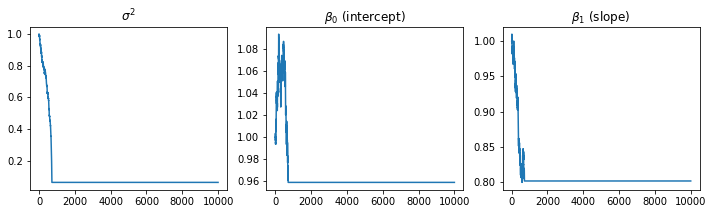

In [19]:
fig, ax = plt.subplots(ncols=3,figsize=(12,3))
ax[0].plot(trace[:,0])
ax[0].set_title(r"$\sigma^2$")
ax[1].plot(trace[:,1])
ax[1].set_title(r"$\beta_0$ (intercept)")
ax[2].plot(trace[:,2])
ax[2].set_title(r"$\beta_1$ (slope)")

plt.show()

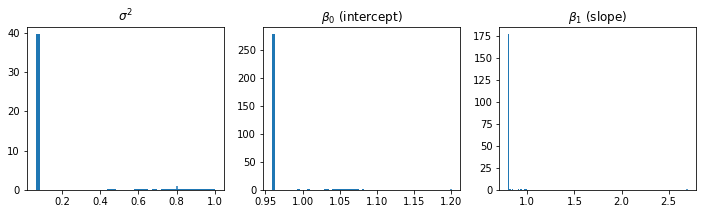

In [20]:
fig, ax = plt.subplots(ncols=3,figsize=(12,3))
ax[0].hist(trace[:,0],density=True,bins=40)
ax[0].set_title(r"$\sigma^2$")
ax[1].hist(trace[:,1],density=True,bins=40)
ax[1].set_title(r"$\beta_0$ (intercept)")
ax[2].hist(trace[:,2],density=True,bins=40)
ax[2].set_title(r"$\beta_1$ (slope)")

y = 1.2 + 2.7 * x + .8*np.random.randn(20)

ax[0].vlines(x=0.8, ymin=0., ymax=1.)
ax[1].vlines(x=1.2, ymin=0., ymax=1.)
ax[2].vlines(x=2.7, ymin=0., ymax=1.)



plt.show()